In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf
import numpy as np
import matplotlib.pyplot as plt
#https://www.data4v.com/tutorial-hierarchical-clustering-in-spark-with-bisecting-k-means/

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
spark = SparkSession.builder \
    .appName('bisectingK') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [4]:
paps = spark.read.json("/home/jovyan/work/2022_SP_6500_FP_Gu_Luchinsky_Mitchell/data/processed/dummy.json/")

In [5]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())
papersWIDs_woNA_woNone = papersWIDs_woNA.filter("None == 0")
print(papersWIDs_woNA_woNone.count())

74
74
66


In [6]:
papersWIDs_woNA_woNone.columns

['12_38_-t',
 '12_38_Bx',
 '13_25_Gv',
 '13_66_Bc',
 '14_40_Pq',
 'CERN_LHC_Coll',
 'J_psi_3100___pair_production',
 'LHC-B',
 'None',
 'branching_ratio',
 'channel_cross_section',
 'charmonium',
 'citation_count',
 'color__octet',
 'color__singlet',
 'electron_positron__annihilation',
 'light_cone',
 'num_refs',
 'number_of_pages',
 'numerical_calculations',
 'p_p__scattering',
 'quantum_chromodynamics__nonrelativistic',
 'quarkonium__heavy',
 'quarkonium__pair_production',
 'title',
 'id']

Included all columns except title and ID since those are strings and identifiers

In [7]:
from pyspark.ml.feature import VectorAssembler
papersWIDs_woNA_woNone.columns
assemble=VectorAssembler(inputCols=[
'12_38_-t',
 '12_38_Bx',
 '13_25_Gv',
 '13_66_Bc',
 '14_40_Pq',
 'CERN_LHC_Coll',
 'J_psi_3100___pair_production',
 'LHC-B',
 'None',
 'branching_ratio',
 'channel_cross_section',
 'charmonium',
 'citation_count',
 'color__octet',
 'color__singlet',
 'electron_positron__annihilation',
 'light_cone',
 'num_refs',
 'number_of_pages',
 'numerical_calculations',
 'p_p__scattering',
 'quantum_chromodynamics__nonrelativistic',
 'quarkonium__heavy',
 'quarkonium__pair_production',
 ], outputCol='features')
assembled_data=assemble.transform(papersWIDs_woNA_woNone)
assembled_data.show(2)

+--------+--------+--------+--------+--------+-------------+----------------------------+-----+----+---------------+---------------------+----------+--------------+------------+--------------+-------------------------------+----------+--------+---------------+----------------------+---------------+---------------------------------------+-----------------+---------------------------+--------------------+---+--------------------+
|12_38_-t|12_38_Bx|13_25_Gv|13_66_Bc|14_40_Pq|CERN_LHC_Coll|J_psi_3100___pair_production|LHC-B|None|branching_ratio|channel_cross_section|charmonium|citation_count|color__octet|color__singlet|electron_positron__annihilation|light_cone|num_refs|number_of_pages|numerical_calculations|p_p__scattering|quantum_chromodynamics__nonrelativistic|quarkonium__heavy|quarkonium__pair_production|               title| id|            features|
+--------+--------+--------+--------+--------+-------------+----------------------------+-----+----+---------------+--------------------

# Scale the Data

In [8]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+--------+--------+--------+--------+--------+-------------+----------------------------+-----+----+---------------+---------------------+----------+--------------+------------+--------------+-------------------------------+----------+--------+---------------+----------------------+---------------+---------------------------------------+-----------------+---------------------------+--------------------+---+--------------------+--------------------+
|12_38_-t|12_38_Bx|13_25_Gv|13_66_Bc|14_40_Pq|CERN_LHC_Coll|J_psi_3100___pair_production|LHC-B|None|branching_ratio|channel_cross_section|charmonium|citation_count|color__octet|color__singlet|electron_positron__annihilation|light_cone|num_refs|number_of_pages|numerical_calculations|p_p__scattering|quantum_chromodynamics__nonrelativistic|quarkonium__heavy|quarkonium__pair_production|               title| id|            features|        standardized|
+--------+--------+--------+--------+--------+-------------+----------------------------+-----

# Fit the model

In [9]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette')
for K in range(2,50):

    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(assembled_data)

    BKMeans_transform=BKMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

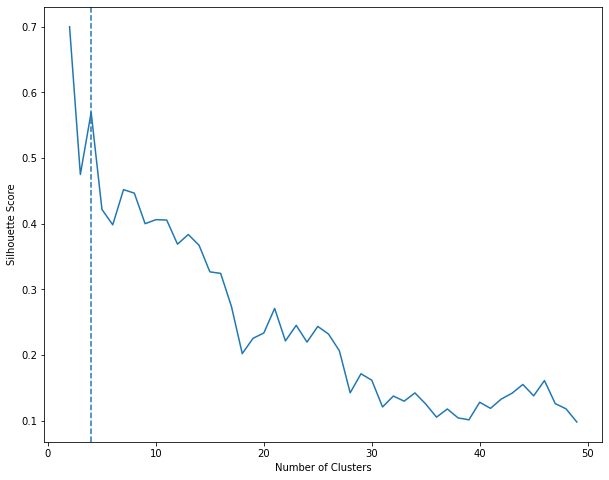

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,50),silhouette_scores)
plt.axvline(x=4, linestyle = "--")
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [11]:
BKMeans_=BisectingKMeans(featuresCol='features', k=4) 
BKMeans_Model=BKMeans_.fit(assembled_data)
BKMeans_transform=BKMeans_Model.transform(assembled_data)

In [12]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [13]:
import numpy as np
X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
X_pca = np.array(X_pca)


In [14]:
cluster_assignment = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

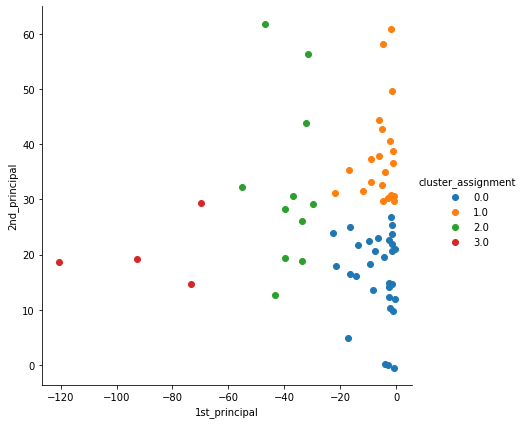

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()

In [16]:
cluster_assignment

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [2],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [2],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [2],
       [2],
       [0],
       [3],
       [0],
       [0],
       [3],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [2],
       [2],
       [2],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [3],
       [0],
       [2],
       [0],
       [2],
       [0],
       [3],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [17]:
BKMeans_transform

12_38_-t,12_38_Bx,13_25_Gv,13_66_Bc,14_40_Pq,CERN_LHC_Coll,J_psi_3100___pair_production,LHC-B,None,branching_ratio,channel_cross_section,charmonium,citation_count,color__octet,color__singlet,electron_positron__annihilation,light_cone,num_refs,number_of_pages,numerical_calculations,p_p__scattering,quantum_chromodynamics__nonrelativistic,quarkonium__heavy,quarkonium__pair_production,title,id,features,prediction
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,35,15,0,0,1,0,0,Charmonia product...,0,"(24,[4,17,18,21],...",1
0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,42,10,0,0,0,0,0,Exclusive decays ...,1,"(24,[9,12,17,18],...",1
0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,40,8,0,0,0,0,0,Doubly heavy bary...,2,"(24,[5,7,12,17,18...",1
0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,21,10,1,0,0,0,0,Weak decays of do...,3,"(24,[12,17,18,19]...",0
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,49,8,0,0,0,0,0,$B_c$ excitations...,4,"(24,[5,7,17,18],[...",1
0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,22,7,1,0,0,0,0,Excited $\rho$ me...,5,"(24,[9,12,17,18,1...",0
0,0,0,0,0,1,0,1,0,0,0,0,30,0,0,0,0,56,14,0,0,0,0,0,Doubly heavy bary...,6,"(24,[5,7,12,17,18...",2
0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,30,9,1,0,1,0,0,Charmonia Product...,7,"(24,[4,9,12,13,17...",1
0,0,0,0,1,0,0,0,0,1,0,0,8,0,0,0,1,36,14,0,0,1,0,0,Double Charmonia ...,9,"(24,[4,9,12,16,17...",1
0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,0,0,22,7,1,0,0,1,0,Muon Pair Product...,10,"(24,[4,9,12,17,18...",0


In [30]:
result = BKMeans_transform.prediction


Column<'prediction'>

In [39]:
BKMeans_transform.groupBy("prediction", "title").agg({"prediction":"count"}).sort(desc("prediction")).show(truncate=False)

+----------+-------------------------------------------------------------------------------------------------------------------------+-----------------+
|prediction|title                                                                                                                    |count(prediction)|
+----------+-------------------------------------------------------------------------------------------------------------------------+-----------------+
|3         |Tetraquarks Composed of 4 Heavy Quarks                                                                                   |1                |
|3         |Double J/psi-meson Production at LHC and 4c-tetraquark state                                                             |1                |
|3         |Excited charmonium mesons production in e+ e- annihilation at s**1/2 = 10.6-GeV                                          |1                |
|3         |The Study of leading twist light cone wave function of eta(c) meson   